# Text emotion detection 

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/tweet_emotions.csv.gz', compression='gzip')

data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


The dataset consists of 3 columns, the `tweet_id`, the `sentiment` (the emotion), and the textual `content`.

## Dataset preparation

In [3]:
print(f'Instances: {len(data["content"])}')
print(f'Unique instances: {len(set(data["content"]))}')
print(f'Unique tweets: {len(set(data["tweet_id"]))}')

Instances: 40000
Unique instances: 39827
Unique tweets: 40000


We have 40k instances to work with, however out of those there are 173 tweets with repeating content. Let's examine some of those instances to see whether they are in different classes

In [4]:
# the amount of rows with the exact same sentiment-content combination
print(sum(data.duplicated(subset=["sentiment", "content"])))

print(data[data["content"] == "Somebody please save the polar bears!"])
print()
print(data[data["content"] == "I'm at work"])

91
       tweet_id sentiment                                content
454  1957075229     worry  Somebody please save the polar bears!
521  1957088574     worry  Somebody please save the polar bears!

        tweet_id sentiment      content
147   1957001506    relief  I'm at work
1026  1957198430   neutral  I'm at work


We therefore have 91 rows which are completely redundant and can be removed from our considerations. On the other hand, we have some contents which were assigned two different classes, in the example of _"I'm at work"_ it is once said to be neutral and once said to be relief (debatable). These instances can be left in as this represents the reality where a single text cannot always be strictly assigned to a single emotion. Also, these instances will act as a low scale reguralizer.

In [5]:
# idempotent removal of duplicates
data = data[~data.duplicated(subset=["sentiment", "content"])]

We will now proceed to examining the class distribution.

### Distribution analysis

<AxesSubplot:xlabel='sentiment', ylabel='instances'>

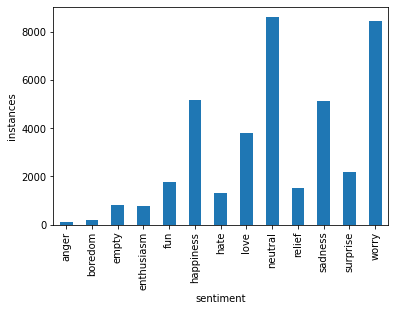

In [46]:
classes = data.groupby("sentiment").nunique()[["tweet_id"]]
classes.plot(kind='bar', ylabel='instances', legend=False)

As we can see, the dataset is not very balanced which might greatly hinder the performance of our classifier. There are a few ways to go about it:

- Removal of classes with a low amount of instances; such as _anger_ or _boredom_
- Augmenting some promising classes with statistical models

Let's additionally check the number of charaters and the number of words in each sentiment class, perhaps this shows a more balanced distribution:

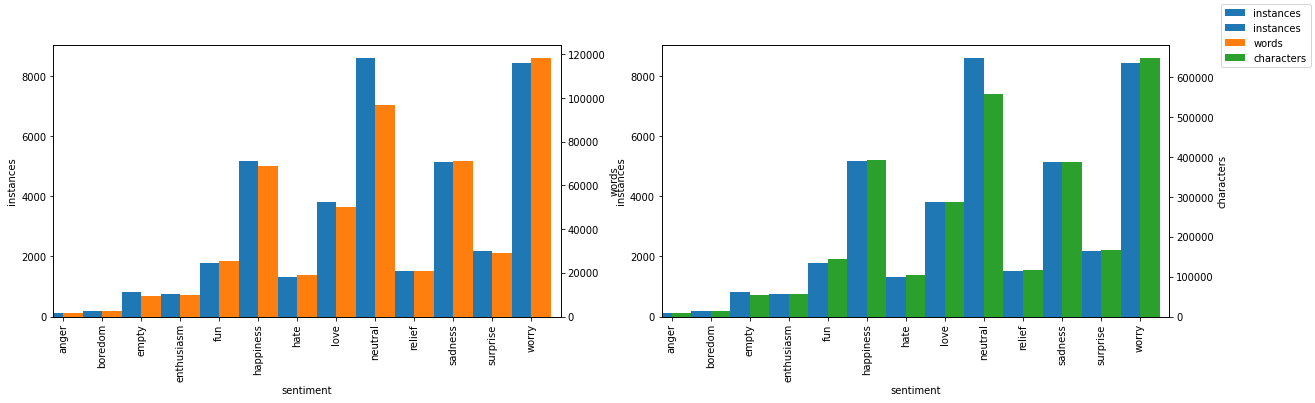

In [117]:
def flatten(l) -> list:
    """flattens a single level of a list"""
    return [x for sublist in l for x in sublist]

def normalized_words(s: str) -> list[str]:
    """Returns words with punctuation removed from a given string, will not deduplicate"""
    import re
    from string import punctuation
    return [w.lower() for w in re.sub(f'[{punctuation}]', '', s).split()]

# calculate needed counts
word_count = []
char_count = []
for sent in classes.axes[0]:
    curr = data[data["sentiment"] == sent]["content"]
    all_words = flatten(normalized_words(c) for c in curr)
    word_count.append(len(all_words))
    char_count.append(sum([len(s) for s in curr]))

# add calculated counts to dataframe
classes["word_count"] = word_count
classes["char_count"] = char_count

# display results in a twin graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

classes[["tweet_id"]].plot(kind='bar', ylabel='instances', position=1, legend=False, ax=ax1)
classes[["word_count"]].plot(kind='bar', ylabel='words', position=0, color='tab:orange', legend=False, ax=ax1.twinx())
classes[["tweet_id"]].plot(kind='bar', ylabel='instances', position=1, legend=False, ax=ax2)
classes[["char_count"]].plot(kind='bar', ylabel='characters', position=0, color='tab:green', legend=False, ax=ax2.twinx())
fig.legend(loc="upper right", labels=["instances", 'instances', 'words', 'characters'])

Unfortunely, as seen in the figures above, word count and characters count distributions follow the instances scaled distribution, leaving us with no extra wiggle room.

### Most common words

Below we calculate the most common words in each class, excluding those that are shared between classes to eliminate universaly most common words such as `I` or `the`.

In [143]:
from collections import Counter

counters = [
    Counter(flatten(
        normalized_words(c) 
        for c in data[data["sentiment"] == sent]["content"]
    ))
    for sent in classes.axes[0]
]

total = Counter()
for c in counters:
    total = total + c
    
univ_common = {w[0] for w in total.most_common(30)}

for i, c in enumerate(counters):
    m = []
    for l in c.most_common():
        if l[0] not in univ_common:
            m.append(l)
            if len(m) == 3:
                break
    print(f'Most common words for {classes.axes[0][i]}: {m}')

Most common words for anger: [('your', 9), ('are', 9), ('out', 9)]
Most common words for boredom: [('bored', 27), ('work', 15), ('out', 15)]
Most common words for empty: [('dont', 47), ('no', 45), ('out', 43)]
Most common words for enthusiasm: [('go', 54), ('up', 53), ('out', 45)]
Most common words for fun: [('lol', 177), ('fun', 141), ('out', 116)]
Most common words for happiness: [('happy', 408), ('thanks', 295), ('great', 292)]
Most common words for hate: [('hate', 209), ('like', 93), ('dont', 88)]
Most common words for love: [('love', 855), ('happy', 592), ('mothers', 568)]
Most common words for neutral: [('now', 427), ('up', 415), ('do', 388)]
Most common words for relief: [('now', 120), ('up', 91), ('thanks', 90)]
Most common words for sadness: [('no', 380), ('sad', 373), ('miss', 339)]
Most common words for surprise: [('are', 136), ('no', 128), ('up', 123)]
Most common words for worry: [('dont', 547), ('get', 539), ('no', 512)]
